# Initial considerations:
- Deleting duplicate records: not necessary as all duplicate records have been removed in NLS-KDD
- In the DB there are no attributes with NULL values, so we don't have to fill in the data (Data Integration process).

## Steps performed:
- import the necessary libraries
- import the dataset
- the distribution of the type of attachments in test set and training set is shown


- Fill missing data in the "service" attribute
- Data transformation from nominal to binary


- mapping labels in 5 categories (Dos, Probe, R2L, U2R, Normal)


- Adjust values
- Remove unnecessary attributes for analysis
- Normalization of values


- Classification
- Pipeline with PCA feature selection with use of RF CLASSIFIER

# 1 - Import library for computation

In [190]:
import os
import time
import pandas as pd
import numpy as np
from collections import Counter
from numpy import where

import matplotlib.pyplot as plt
from collections import defaultdict #dict subclass that calls a factory function to supply missing values
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# options for custom visualization
#pd.set_option('display.max_columns', None)
#np.set_printoptions(linewidth=160)
#pd.options.display.max_rows = 999
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

# 2 - Load Dataset

In [191]:
dataset_root = 'datasets/nsl-kdd'
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
                'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 
                'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
                'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
                'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

# Read in the data from the CSV file into a a dataframe 
df_training = pd.read_csv(train_file, names = header_names)
df_test = pd.read_csv(test_file, names = header_names)
print("dimension training set: ", df_training.shape)
print("dimension test set: ",df_test.shape)


dimension training set:  (125973, 43)
dimension test set:  (22544, 43)


# 3 - View of training set

In [192]:
# Visualize a snippet of the data frame df
df_training.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,success_pred
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


#### we retrieve a quick and easy description of the data (total rows, type attributes, number of non-null values)

In [193]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

## Distribution of attacks in Test set and Training set

<AxesSubplot:>

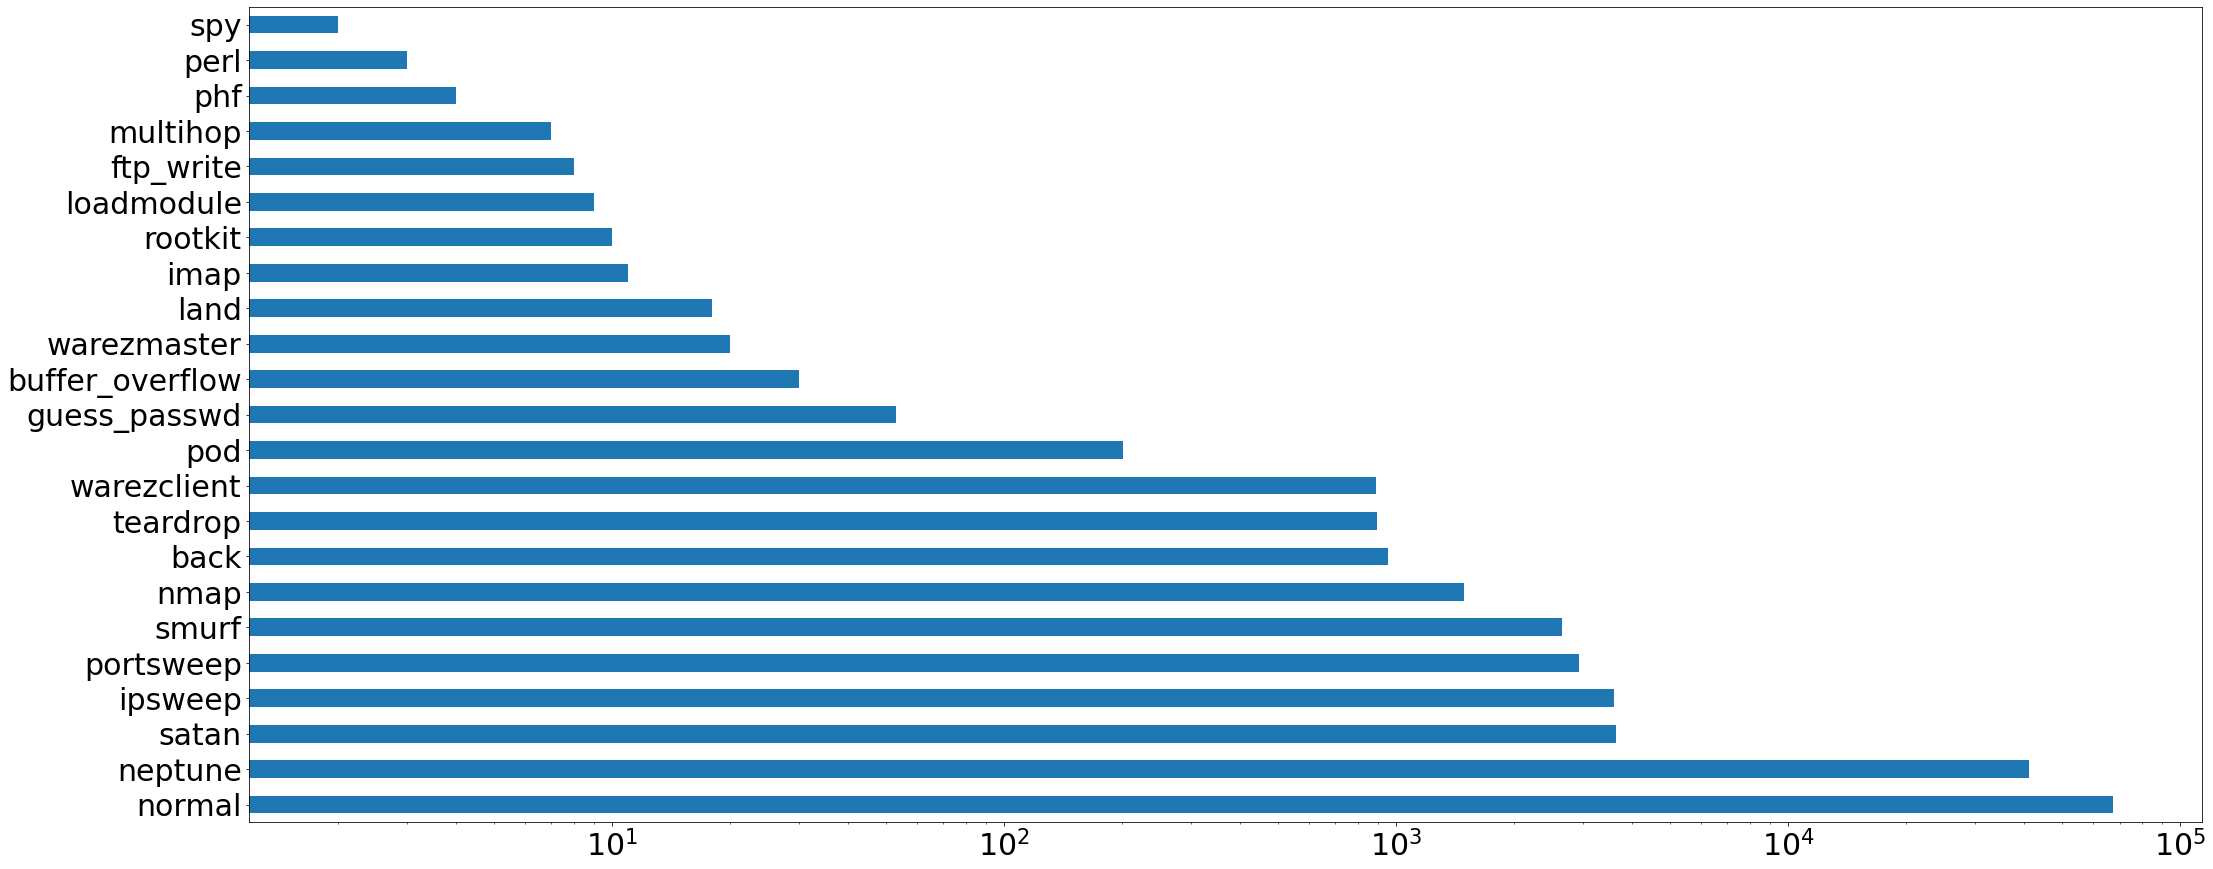

In [194]:
#print graph for see uniformity TRAINING SET
train_attack_labels = df_training['attack_type'].value_counts()
train_attack_labels.plot(kind='barh',logx=True, figsize=(35,15), fontsize=30)

<AxesSubplot:>

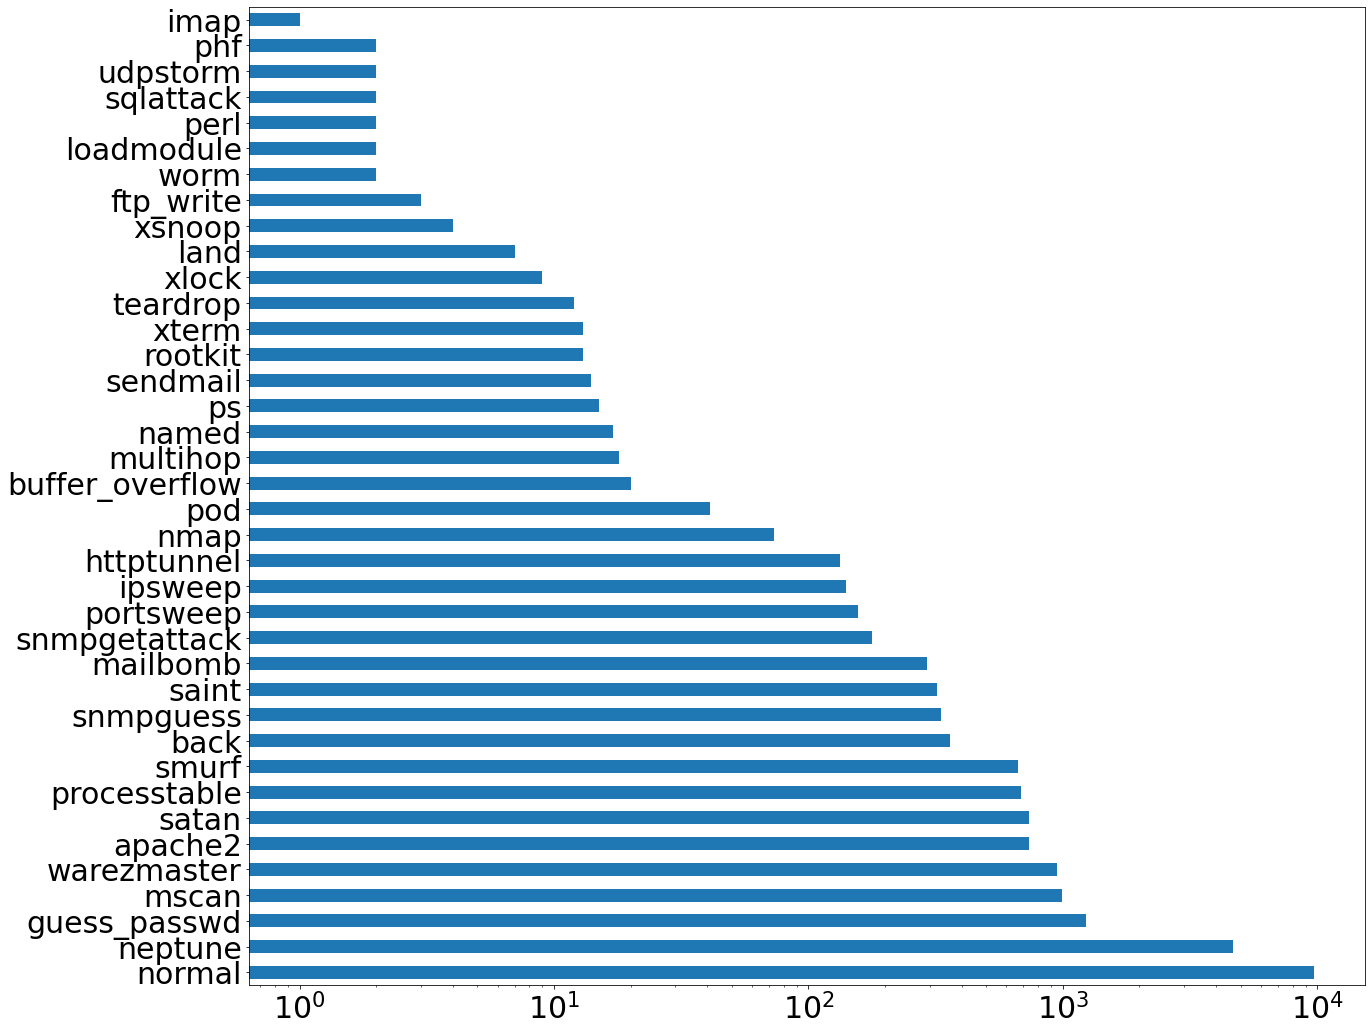

In [195]:
#print graph for see uniformity TEST SET
test_attack_labels = df_test['attack_type'].value_counts()
test_attack_labels.plot(kind='barh',logx=True, figsize=(20,18), fontsize=30)

# 4 -  Data pre-processing: transform categorical into binary

As you can see from the previous info, not all attributes are numeric, let's analyze these types of attributes:

In [196]:
# distinguish between nominal (categorical) / binary / numeric attributes
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))


nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

print(nominal_cols)
print("")
print(binary_cols)
print("")
print(numeric_cols)

['protocol_type', 'service', 'flag']

['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [197]:
#Training set
print("Training set:")
print("values in protocol_type:", len(df_training["protocol_type"].value_counts()))
print("values in service:", len(df_training["service"].value_counts()))
print("values in flag:", len(df_training["flag"].value_counts()))
print("values in attack_type:", len(df_training["attack_type"].value_counts()))
print("")

#Test set
print("Test set:")
print("values in protocol_type:", len(df_test["protocol_type"].value_counts()))
print("values in service:", len(df_test["service"].value_counts()))
print("values in flag:", len(df_test["flag"].value_counts()))
print("values in attack_type:", len(df_test["attack_type"].value_counts()))

Training set:
values in protocol_type: 3
values in service: 70
values in flag: 11
values in attack_type: 23

Test set:
values in protocol_type: 3
values in service: 64
values in flag: 11
values in attack_type: 38


#### The comparison of the results shows that the test set has fewer categories (6), these must be added as empty columns:
- transform Nominal attribute into binary attribute - TRAINING
- transofrm Nominal attribute into binary attribute - TEST
- add column in test set.

In [198]:
#save fault values of service in Test set that we need to add after dummies
training_service=df_training['service'].tolist()
test_service= df_test['service'].tolist()

difference=list(set(training_service) - set(test_service))
string = 'service_'
difference=[string + x for x in difference]


In [199]:
# Make column names for dummies - TRAINING SET
df_training = pd.get_dummies(df_training, columns=nominal_cols, drop_first=True, dtype=float)
df_training.head()

# Make column names for dummies - TEST SET
df_test = pd.get_dummies(df_test, columns=nominal_cols, drop_first=True,dtype=float)

In [200]:
for col in difference:
    df_test[col] = 0
df_test.shape

(22544, 121)

## Reorder the columns of training_set and test_set

In [201]:
# I reorder the columns of the test set according to those of the order of the training set
new_col_names= df_training.columns.tolist()

df_test = df_test.reindex(columns=new_col_names)
df_training = df_training.reindex(columns=new_col_names)
print("sorted done")

sorted done


#### check dissimilarity in columns

In [202]:
# check if the columns are the same
count = 0
for item in df_training.columns.tolist():
    if df_test.columns[count] != item:
        print("different column")
        print(df_test.columns[count],item)
    count+=1

Now both training-set and test-set have the same number of columns and are in the same order

In [203]:
df_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Columns increased from 43 to 121


#### Numbers and binary attributes remain in the dataset, it is not necessary to discretize the numeric attributes, as it is already done automatically during the classification

# 5 - Mapping 22 attacks into 5 categories
We replace in the dataframe each specific attack (22 types) in one of the 5 mapped

<AxesSubplot:>

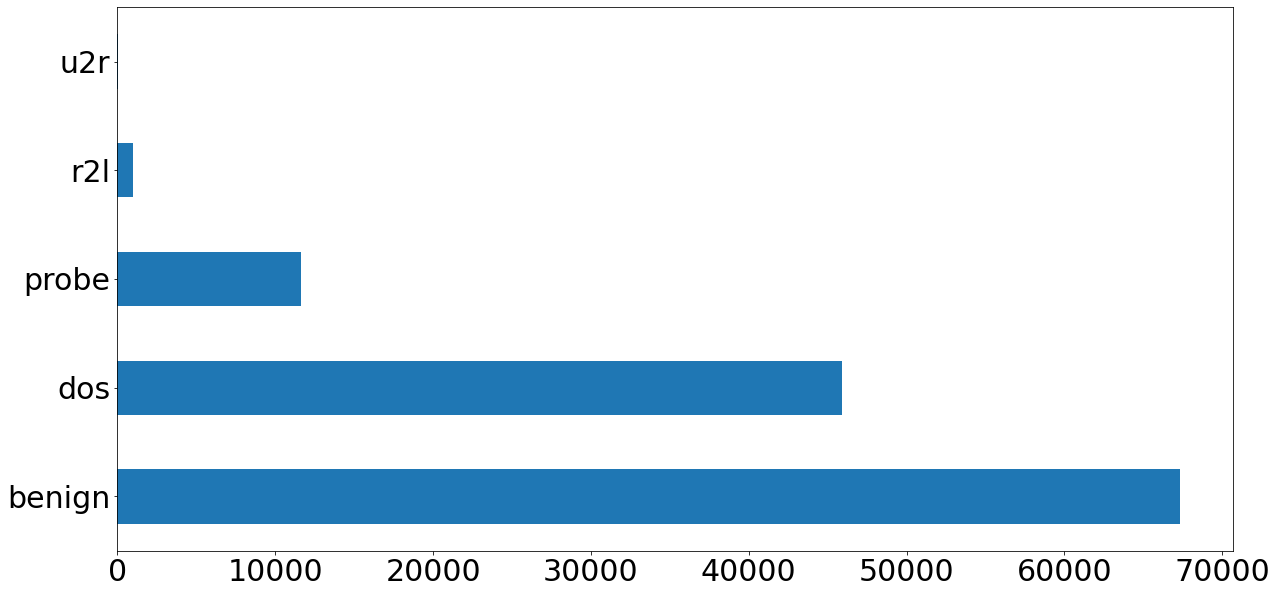

In [204]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 5 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

#mapping in the 5 categories -TEST and TRAINING SET
attack_mapping = dict((v,k) for k in category for v in category[k])

#TRAINING SET
df_training['attack_category'] = df_training['attack_type'].map(lambda x: attack_mapping[x])

#TEST SET
df_test['attack_category'] = df_test['attack_type'].map(lambda x: attack_mapping[x])

#print graph for see uniformity
train_attack_cats = df_training['attack_category'].value_counts()
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<AxesSubplot:>

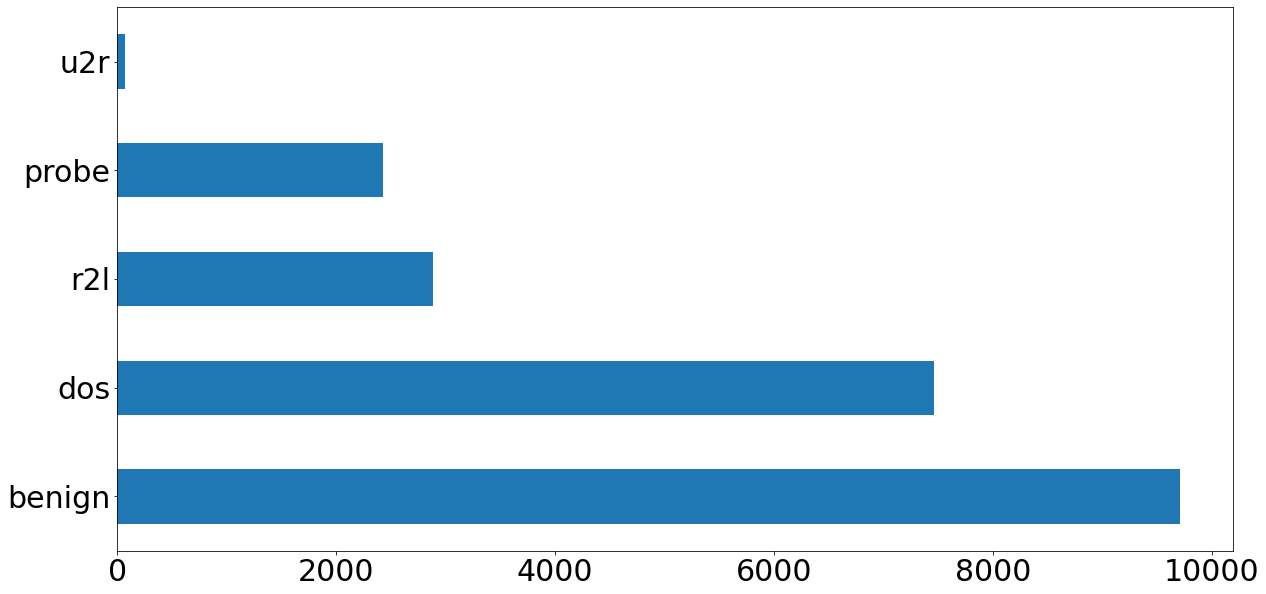

In [205]:
test_attack_cats = df_test['attack_category'].value_counts()
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

### The dataset is heavily unbalanced

# 6 - Adjust values
By definition we cannot have binary attributes greater than 2:
- we see that "su_attempted" does not respect this condition, so let's settle it assuming that 2 -> 0

In [206]:
df_training[binary_cols].describe()

,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.000198,0.395736,0.001342,0.001103,0.000008,0.009423
std,0.014086,0.489010,0.036603,0.045154,0.002817,0.096612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


In [207]:
print("***before:***")
print(df_training.groupby(['su_attempted']).size())
print("")

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0
print("***after:***")
df_training['su_attempted'].replace(2, 0, inplace=True)
print(df_training.groupby(['su_attempted']).size())

***before:***
su_attempted
0    125893
1        21
2        59
dtype: int64

***after:***
su_attempted
0    125952
1        21
dtype: int64


#### do the same even for the TEST SET:

In [208]:
df_test[binary_cols].describe()

,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login
count,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,0.000311,0.442202,0.002440,0.000266,0.000488,0.028433
std,0.017619,0.496659,0.049334,0.021060,0.022084,0.166211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


In [209]:
print("***before:***")
print(df_test.groupby(['su_attempted']).size())
print("")

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0
print("***after:***")
df_test['su_attempted'].replace(2, 0, inplace=True)
print(df_test.groupby(['su_attempted']).size())

***before:***
su_attempted
0    22540
1        2
2        2
dtype: int64

***after:***
su_attempted
0    22542
1        2
dtype: int64


In [210]:
df_training[binary_cols].describe()

,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.000198,0.395736,0.001342,0.000167,0.000008,0.009423
std,0.014086,0.489010,0.036603,0.012910,0.002817,0.096612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 7 - Delete unecessary attribute
Now we see that:
- **num_outbound_cmds** -> has only one value for all entries
- **success_pred** -> is useless for our analysis, as it refers to "how many algorithms" have correctly labeled that entry
- **attack type** is useless, as we have a lower granularity with attack_category introduced previously

These 3 attributes can be eliminated without impacting the analysis. Let's remove them from both the training set and the test set

In [211]:
# first of all we see that all attributes that have only one value: only num_outbound_cmds respects this condition
print("training set:")
for col_name in df_training.columns:
    if len(df_training.groupby([col_name]).size()) == 1:
        print(col_name)

print("test set:")
for col_name in df_test.columns:
    if len(df_training.groupby([col_name]).size()) == 1:
        print(col_name)

training set:
num_outbound_cmds
test set:
num_outbound_cmds


In [212]:
# Delete Attributes

# Training Set:
df_training.drop(['success_pred'], axis=1, inplace=True) # not of interest
df_training.drop(['attack_type'], axis=1, inplace=True) # not of interest
df_training.drop(['num_outbound_cmds'], axis=1, inplace=True) # not of interest

# Test Set:
df_test.drop(['success_pred'], axis=1, inplace=True) # not of interest
df_test.drop(['attack_type'], axis=1, inplace=True) # not of interest
df_test.drop(['num_outbound_cmds'], axis=1, inplace=True) # not of interest

numeric_cols.remove('num_outbound_cmds')

In [213]:
print("dimension training set: ",df_training.shape)
print("dimension test set: ", df_training.shape)

dimension training set:  (125973, 119)
dimension test set:  (125973, 119)


# Data Mining - Extract Y_training & X_Training | Extract X_test & Y_test

### estrazione training set

In [214]:
# estraiamo il vettore con le labels
y_train = df_training['attack_category']
print("shape y_train: ", y_train.shape)

# estraiamo la matrice con gli attributi
df_training.drop(['attack_category'], axis=1, inplace=True)
x_train = df_training
print("shape x_train: ", x_train.shape)

shape y_train:  (125973,)
shape x_train:  (125973, 118)


### test set extraction

In [215]:
# we extract the vector with the labels
y_test = df_test['attack_category']
print("shape y_test: ", y_test.shape)

#extract the matrix with the attributes
df_test.drop(['attack_category'], axis=1, inplace=True)
x_test = df_test
print("shape x_test: ", x_test.shape)

shape y_test:  (22544,)
shape x_test:  (22544, 118)


# 8 - Normalize values
The scikit-learn library includes the sklearn.preprocessing.StandardScaler class that provides this functionality.

In [216]:
x_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.0,0.0,0.0,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.0,44.0,276.0,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.0,0.0,516.0,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.0,0.0,0.0,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.0,0.0,0.0,3.000000e+00
...,...,...,...,...,...,...,...,...
flag_S1,125973.0,0.002897,5.375011e-02,0.0,0.0,0.0,0.0,1.000000e+00
flag_S2,125973.0,0.001008,3.173553e-02,0.0,0.0,0.0,0.0,1.000000e+00
flag_S3,125973.0,0.000389,1.971862e-02,0.0,0.0,0.0,0.0,1.000000e+00
flag_SF,125973.0,0.594929,4.909077e-01,0.0,0.0,1.0,1.0,1.000000e+00


In [217]:
x_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,22544.0,218.859076,1407.176612,0.0,0.0,0.0,0.0,57715.0
src_bytes,22544.0,10395.450231,472786.431088,0.0,0.0,54.0,287.0,62825648.0
dst_bytes,22544.0,2056.018808,21219.297609,0.0,0.0,46.0,601.0,1345927.0
land,22544.0,0.000311,0.017619,0.0,0.0,0.0,0.0,1.0
wrong_fragment,22544.0,0.008428,0.142599,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
flag_S1,22544.0,0.000932,0.030507,0.0,0.0,0.0,0.0,1.0
flag_S2,22544.0,0.000665,0.025787,0.0,0.0,0.0,0.0,1.0
flag_S3,22544.0,0.011045,0.104516,0.0,0.0,0.0,0.0,1.0
flag_SF,22544.0,0.659821,0.473780,0.0,0.0,1.0,1.0,1.0


In [218]:
scaler1 = preprocessing.StandardScaler().fit(x_train)
x_train=scaler1.transform(x_train)

scaler2 = preprocessing.StandardScaler().fit(x_test)
x_test=scaler2.transform(x_test) 

In [219]:
# print variance for dataset
print("training_set")
print(x_train.std(axis=0))
print()
print("test_set")
print(x_test.std(axis=0))

training_set
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

test_set
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [220]:
# We will need later - splitting df_train:
# 1/3 test set
# 2/3 training set
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train,y_train, test_size=0.33)

# Classification with DECISION TREE

## Training decision Tree with training_set

In [221]:
# classifier declaration
clf_dt = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=7)

# training with training_set
clf_dt = clf_dt.fit(x_train, y_train)

# prediction
y_pred_dt = clf_dt.predict(x_test)

# confusion matrix
pd.crosstab(y_test, y_pred_dt, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l
Actual attacks,,,,
benign,8225,768,718,0
dos,1015,6089,354,0
probe,73,554,1796,0
r2l,1110,820,800,155
u2r,13,25,29,0


In [222]:
print("***METRICS EVALUATING TEST SET***") 
print()
print("accuracy: ",clf_dt.score(x_test,y_test))
print()
print(classification_report(y_test, y_pred_dt, target_names=category, zero_division=0))

***METRICS EVALUATING TEST SET***

accuracy:  0.7214779985805536

              precision    recall  f1-score   support

      benign       0.79      0.85      0.82      9711
         dos       0.74      0.82      0.77      7458
         u2r       0.49      0.74      0.59      2423
         r2l       1.00      0.05      0.10      2885
       probe       0.00      0.00      0.00        67

    accuracy                           0.72     22544
   macro avg       0.60      0.49      0.46     22544
weighted avg       0.76      0.72      0.68     22544



## Training Decision Tree with train_splitted

In [223]:
# declaration of new classifier
clf_dt_split = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=7)

# training with training_set
clf_dt_split = clf_dt_split.fit(x_train_split, y_train_split)

# prediction
y_pred_dt_split = clf_dt_split.predict(x_test_split)

# confusion matrix
pd.crosstab(y_test_split, y_pred_dt_split, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l,u2r
Actual attacks,,,,,
benign,22077,15,28,9,2
dos,17,15215,7,0,0
probe,29,16,3810,6,0
r2l,11,0,1,311,2
u2r,6,0,0,0,10


In [224]:
print("***METRICS EVALUATING TEST SET WITH TRAINING WITH 1/3 OF TEST SPLIT TAKEN FROM TRAINING SET***") 
print()
print("accuracy: ",clf_dt.score(x_train_split,y_train_split))
print()
print(classification_report(y_test_split, y_pred_dt_split, target_names=category))

***METRICS EVALUATING TEST SET WITH TRAINING WITH 1/3 OF TEST SPLIT TAKEN FROM TRAINING SET***

accuracy:  0.9981279842655892

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     22131
         dos       1.00      1.00      1.00     15239
         u2r       0.99      0.99      0.99      3861
         r2l       0.95      0.96      0.96       325
       probe       0.71      0.62      0.67        16

    accuracy                           1.00     41572
   macro avg       0.93      0.91      0.92     41572
weighted avg       1.00      1.00      1.00     41572



# 2 - Classification with RANDOM FOREST

## Training RANDOM FOREST with training set

In [225]:
start_time = time.perf_counter()

cfl_rf = RandomForestClassifier(n_estimators=100, criterion = 'gini', random_state = 0)
cfl_rf.fit(x_train, y_train)

end_time = time.perf_counter()

print(end_time - start_time, "seconds")

9.156773257999703 seconds


In [226]:
# Apply the classifier we trained to the test data (which it has never seen before)
y_pred_rf=cfl_rf.predict(x_test)

# Create confusion matrix
pd.crosstab(y_test, y_pred_rf, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l
Actual attacks,,,,
benign,9192,63,456,0
dos,2400,1912,3146,0
probe,676,166,1581,0
r2l,2777,0,107,1
u2r,67,0,0,0


In [227]:
print("***METRICS EVALUATING TEST SET***")
print()
print("accuracy: ",cfl_rf.score(x_train, y_train))
print()
print(classification_report(y_test, y_pred_rf, target_names=category, zero_division=0))

***METRICS EVALUATING TEST SET***

accuracy:  0.999944432537131

              precision    recall  f1-score   support

      benign       0.61      0.95      0.74      9711
         dos       0.89      0.26      0.40      7458
         u2r       0.30      0.65      0.41      2423
         r2l       1.00      0.00      0.00      2885
       probe       0.00      0.00      0.00        67

    accuracy                           0.56     22544
   macro avg       0.56      0.37      0.31     22544
weighted avg       0.72      0.56      0.49     22544



## Training RANDOM FOREST with training_split set

In [228]:
start_time = time.perf_counter()

cfl_rf_split = RandomForestClassifier(n_estimators=100, criterion = 'gini', random_state = 0)
cfl_rf_split.fit(x_train_split, y_train_split)

end_time = time.perf_counter()

print(end_time - start_time, "seconds")

9.022086554999987 seconds


In [229]:
# Apply the classifier we trained to the test data (which it has never seen before)
y_pred_rf_split=cfl_rf_split.predict(x_test_split)

# Create confusion matrix
pd.crosstab(y_test_split, y_pred_rf_split, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l,u2r
Actual attacks,,,,,
benign,22122,5,4,0,0
dos,1,15237,1,0,0
probe,17,0,3844,0,0
r2l,10,0,0,315,0
u2r,8,0,0,0,8


In [230]:
print("***METRICS EVALUATING TEST SET with splitted***")
print()
print("accuracy: ",cfl_rf.score(x_train_split, y_train_split))
print()
print(classification_report(y_test_split, y_pred_rf_split, target_names=category, zero_division=0))

***METRICS EVALUATING TEST SET with splitted***

accuracy:  0.9999644553974479

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     22131
         dos       1.00      1.00      1.00     15239
         u2r       1.00      1.00      1.00      3861
         r2l       1.00      0.97      0.98       325
       probe       1.00      0.50      0.67        16

    accuracy                           1.00     41572
   macro avg       1.00      0.89      0.93     41572
weighted avg       1.00      1.00      1.00     41572



# Classification with Naive Bayes

In [231]:
#Create a Gaussian Classifier
clf_bayes = GaussianNB()

# Train the model using the training sets
clf_bayes.fit(x_train,y_train)

y_pred_bayes=clf_bayes.predict(x_test)

pd.crosstab(y_test, y_pred_bayes, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l
Actual attacks,,,,
benign,81,52,9578,0
dos,12,48,7398,0
probe,0,0,2423,0
r2l,22,0,2862,1
u2r,40,0,27,0


In [232]:
print("***METRICS EVALUATING TEST SET***")
print()
print("accuracy: ",clf_bayes.score(x_train, y_train))
print()
print(classification_report(y_test, y_pred_bayes, target_names=category, zero_division=0))

***METRICS EVALUATING TEST SET***

accuracy:  0.650671175569368

              precision    recall  f1-score   support

      benign       0.52      0.01      0.02      9711
         dos       0.48      0.01      0.01      7458
         u2r       0.11      1.00      0.20      2423
         r2l       1.00      0.00      0.00      2885
       probe       0.00      0.00      0.00        67

    accuracy                           0.11     22544
   macro avg       0.42      0.20      0.05     22544
weighted avg       0.52      0.11      0.03     22544



## Training NAIVE BAYES with training split set

In [233]:
#Create a Gaussian Classifier
clf_bayes_split = GaussianNB()

# Train the model using the training sets
clf_bayes_split.fit(x_train_split,y_train_split)

y_pred_bayes_split=clf_bayes_split.predict(x_test_split)

pd.crosstab(y_test_split, y_pred_bayes_split, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,benign,dos,probe,r2l,u2r
Actual attacks,,,,,
benign,12662,59,3,7779,1628
dos,1808,13095,23,313,0
probe,2800,124,680,189,68
r2l,1,0,0,169,155
u2r,1,0,0,2,13


In [234]:
print("***METRICS EVALUATING TEST SET***")
print()
print("accuracy: ",clf_bayes_split.score(x_train_split, y_train_split))
print()
print(classification_report(y_test_split, y_pred_bayes_split, target_names=category, zero_division=0))

***METRICS EVALUATING TEST SET***

accuracy:  0.6412483264416299

              precision    recall  f1-score   support

      benign       0.73      0.57      0.64     22131
         dos       0.99      0.86      0.92     15239
         u2r       0.96      0.18      0.30      3861
         r2l       0.02      0.52      0.04       325
       probe       0.01      0.81      0.01        16

    accuracy                           0.64     41572
   macro avg       0.54      0.59      0.38     41572
weighted avg       0.84      0.64      0.71     41572



# Pipeline with feature selection PCA and Random Forest Classificator

In [235]:
estimators = [('reduce_dim', PCA()), ('clf_rf_s', RandomForestClassifier(n_estimators=100, criterion = 'gini', random_state = 0))]
pipe = Pipeline(estimators)
pipe.fit(x_train,y_train)
y_pred_s = pipe.predict(x_test)
print(classification_report(y_test, y_pred_s, target_names=category, zero_division=0))

              precision    recall  f1-score   support

      benign       0.65      0.97      0.78      9711
         dos       0.96      0.76      0.85      7458
         u2r       0.80      0.68      0.74      2423
         r2l       1.00      0.00      0.00      2885
       probe       0.00      0.00      0.00        67

    accuracy                           0.74     22544
   macro avg       0.68      0.48      0.47     22544
weighted avg       0.81      0.74      0.70     22544

